**pip:**
Python's package installer.
**install:**
Command to add new packages.

**Packages:**
**tensorflow:** Open-source library for machine learning and deep learning tasks. Used for building, training, and evaluating the model.
**opencv-python:**
Library for computer vision tasks. Used for image processing like loading and resizing.
**scikit-learn:**
Library for traditional machine learning algorithms. Used for data splitting, text vectorization, and evaluation metrics.






In [1]:
!pip install tensorflow opencv-python scikit-learn


# 1. Data Exploration and Preprocessing:
**Load & Preprocess Image Data:**
We navigate through the dataset's directory structure to read images. Each image is loaded in grayscale, resized to 128x128 pixels for uniformity, and normalized (pixel values scaled between 0 and 1). Corresponding labels (class names) for each image are also stored.

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

DATA_DIR = "C:\\Users\\hp\\Downloads\\MachineLearningEngineerTest\\ML\\data"
IMAGE_DIR = os.path.join(DATA_DIR, "images")
OCR_DIR = os.path.join(DATA_DIR, "ocr")

# Lists to store data
image_data = []
text_data = []
labels = []

# Load images and their corresponding OCR texts
for class_name in os.listdir(IMAGE_DIR):
    class_image_dir = os.path.join(IMAGE_DIR, class_name)
    class_ocr_dir = os.path.join(OCR_DIR, class_name)
    
    for image_name in os.listdir(class_image_dir):
        # Image preprocessing
        image_path = os.path.join(class_image_dir, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (128, 128)) / 255.0
        image_data.append(image)
        
        # OCR Text loading
        text_path = os.path.join(class_ocr_dir, image_name + ".txt")
        with open(text_path, 'r', encoding='utf-8') as file:

            text = file.read().replace('\n', '')
    
            text_data.append(text)

        
        labels.append(class_name)

image_data = np.array(image_data).reshape(-1, 128, 128, 1)
labels = np.array(labels)


In [3]:
labels

array(['0', '0', '0', ..., '9', '9', '9'], dtype='<U1')

**Preprocess Text Data:**

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
vectorized_text_data = vectorizer.fit_transform(text_data).toarray()


In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
labels = encoder.fit_transform(labels)


In [6]:
labels

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

**Label Encoding**:I noticed that while preparing the dataset, I kept the labels as string values (like "0", "2", etc.). Most ML models require numerical labels. So, we need to convert these string labels to numerical values.

# 2. Splitting the Data:
We divide the dataset into training and testing subsets. The training set is used to train the model, while the testing set is reserved to evaluate the model's performance on unseen data. This ensures that we get a fair assessment of how well our model is likely to perform in real-world scenarios.

In [7]:
# Splitting both image and text data
train_image_data, test_image_data, train_text_data, test_text_data, train_labels, test_labels = train_test_split(image_data, vectorized_text_data, labels, test_size=0.2, random_state=42)


# 3. Building the Hybrid Model:
**Construct the Model Architecture:
We create a dual-branch model:**

One branch (CNN) processes images, capturing visual features.
The other branch (Dense layers) processes text data from OCR.
The outputs of both branches are then combined and passed through final layers to produce a class prediction. This hybrid approach allows the model to learn from both image and text data simultaneously.

In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

# Image input branch - CNN
image_input = Input(shape=(128, 128, 1))
x1 = Conv2D(32, (3,3), activation='relu')(image_input)
x1 = MaxPooling2D(2, 2)(x1)
x1 = Flatten()(x1)
x1 = Dense(128, activation='relu')(x1)

# Text input branch - Dense layers
text_input = Input(shape=(5000,))
x2 = Dense(512, activation='relu')(text_input)
x2 = Dense(128, activation='relu')(x2)

# Combine both branches
combined = Concatenate()([x1, x2])
z = Dense(256, activation='relu')(combined)
z = Dense(5, activation='softmax')(z)  # Assuming 5 classes based on the given dataset

hybrid_model = Model(inputs=[image_input, text_input], outputs=z)
hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [9]:
hybrid_model

In [10]:
hybrid_model.compile

<bound method Model.compile of <keras.src.engine.functional.Functional object at 0x000001DDB1B2FD60>>

# 4. Train the Hybrid Model:
We feed the training data (both images and text) into the hybrid model, allowing it to adjust and learn the best weights to correctly predict the labels. The training process iteratively adjusts the model's weights using the provided data for a specified number of rounds (epochs) to minimize prediction errors.






In [11]:

hybrid_model.fit([train_image_data, train_text_data], train_labels, epochs=10, validation_split=0.1, batch_size=32)


Epoch 1/10
57/57 [==============================] - 32s 507ms/step - loss: 1.7889 - accuracy: 0.5161 - val_loss: 0.5989 - val_accuracy: 0.7200
Epoch 2/10
57/57 [==============================] - 27s 480ms/step - loss: 0.2620 - accuracy: 0.9117 - val_loss: 0.4380 - val_accuracy: 0.8300
Epoch 3/10
57/57 [==============================] - 27s 482ms/step - loss: 0.0551 - accuracy: 0.9861 - val_loss: 0.4495 - val_accuracy: 0.8600
Epoch 4/10
57/57 [==============================] - 28s 500ms/step - loss: 0.0243 - accuracy: 0.9939 - val_loss: 0.4554 - val_accuracy: 0.8600
Epoch 5/10
57/57 [==============================] - 27s 482ms/step - loss: 0.0145 - accuracy: 0.9961 - val_loss: 0.5888 - val_accuracy: 0.8500
Epoch 6/10
57/57 [==============================] - 28s 499ms/step - loss: 0.0105 - accuracy: 0.9978 - val_loss: 0.5079 - val_accuracy: 0.8500
Epoch 7/10
57/57 [==============================] - 28s 483ms/step - loss: 0.0083 - accuracy: 0.9972 - val_loss: 0.5404 - val_accuracy: 0.8250

# 5. Model Evaluation:
**Evaluate Model and Extract Metrics:**
After training, we test the model's performance using the testing data that it hasn't seen before. By comparing the model's predictions to the true labels, we calculate metrics like precision, recall, F1-score, and the confusion matrix. These metrics provide insights into how accurately and consistently the model predicts, as well as areas where it might be making errors. This step ensures that the model is reliable and performs well on new, unseen data.

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
predictions = hybrid_model.predict([test_image_data, test_text_data])
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_labels

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels)



print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(cm)


16/16 [==============================] - 2s 121ms/step
Precision: 0.8633263374679275
Recall: 0.844
F1 Score: 0.847014978986657
Accuracy: 0.844
Confusion Matrix:
[[94  0  2  1  3]
 [11 73  0  0  4]
 [ 4  0 88  1 15]
 [ 4  0  4 87 16]
 [ 6  2  2  3 80]]


# 1. Metrics Bar Chart:
This is a simple bar chart that represents the four metrics (Precision, Recall, F1 Score, and Accuracy) used to evaluate the model's performance.

**Precision:** It tells us how many of the items identified as a specific class were actually that class. A high precision means that the model returned substantially more relevant results than irrelevant ones.

**Recall:** It tells us how many of the actual positive cases we caught. A high recall means that the model identified most of the positive cases.

**F1 Score:** The harmonic mean of precision and recall. It provides a single score that balances both the concerns of precision and recall in one number.

**Accuracy:** The ratio of correctly predicted observation to the total observations. It gives a general overview of how often the classifier is correct.

The Y-axis represents the value of the metric (ranging from 0 to 1), and the X-axis has the names of the metrics. The height of the bars gives a visual sense of the performance value for each metric.

**2. Confusion Matrix Heatmap:**
A confusion matrix is a table that is used to evaluate the performance of a classification model. Each row represents the actual class, and each column represents the predicted class.

**For a binary classification:**

**True Positives (TP):** Actual positives that are correctly identified as positive.
**True Negatives (TN):** Actual negatives that are correctly identified as negative.
**False Positives (FP):** Actual negatives that are incorrectly identified as positive.
**False Negatives (FN):** Actual positives that are incorrectly identified as negative.

In the case of multi-class classification, the matrix will be larger, but the principle is the same. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier.

The heatmap provides color-coded visualization for the confusion matrix. Darker shades typically represent higher numbers (i.e., more observations). By looking at the heatmap, one can quickly grasp where the model is making mistakes. Ideally, we'd like to see dark shades (high values) on the diagonal and lighter shades (low values) on the off-diagonal.

**To summarize:**

The Metrics Bar Chart gives a quick overview of the model's overall performance.
The Confusion Matrix Heatmap provides detailed insights into the types of mistakes the model is making for each class.

In [13]:
!pip install matplotlib seaborn


# 1. Visualize Metrics in a Bar Chart:

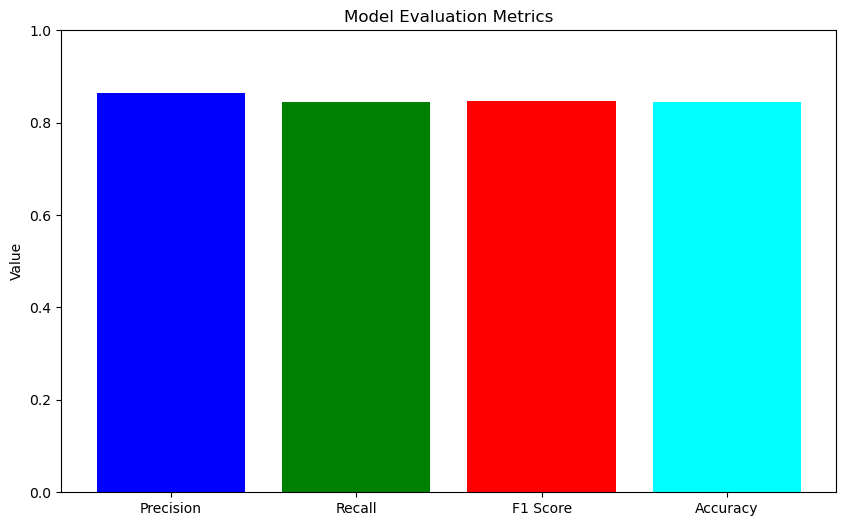

In [14]:
import matplotlib.pyplot as plt

# Metrics data
metrics_values = [precision, recall, f1, accuracy]
metrics_names = ['Precision', 'Recall', 'F1 Score', 'Accuracy']

# Bar chart
plt.figure(figsize=(10,6))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'cyan'])
plt.ylim(0, 1)  # set the y-axis limits to be between 0 and 1 for better visualization
plt.title('Model Evaluation Metrics')
plt.ylabel('Value')
plt.show()


# 2. Visualize Confusion Matrix as a Heatmap:

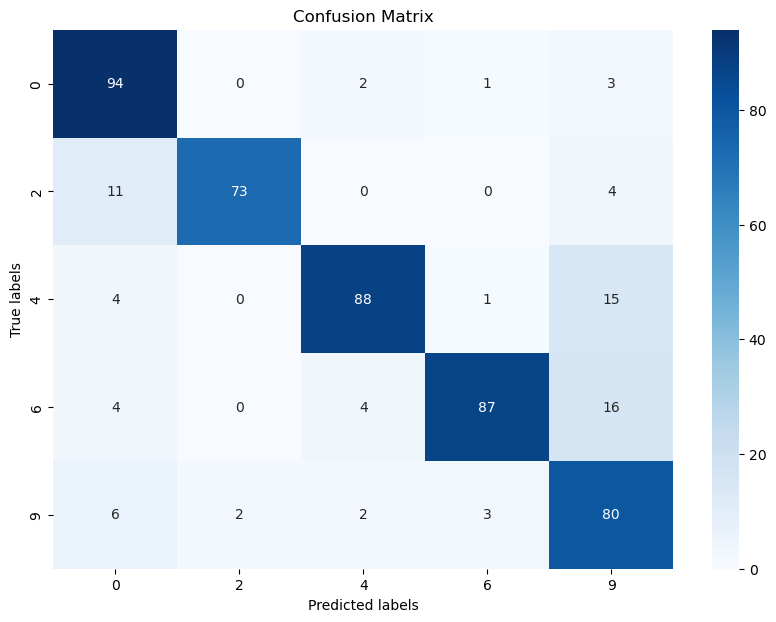

In [15]:
import seaborn as sns

# Heatmap of confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# 6. Save the Trained Model:
After training a model, it's essential to save its architecture and learned weights. This allows us to:

**Reuse:** Deploy the model in different environments or applications without retraining.
**Share:** Distribute the model to colleagues or transfer between projects.
**Deploy:** Use the model in production systems, web apps, or mobile applications

In [16]:
hybrid_model.save("hybrid_image_text_model.h5")


C:\Users\hp\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Now checking the model whether itys working or not by loading the saved model and making predictions,calculating the test accuracy and to provide a visual inspection of the model's predictions on a few randomly selected test images.

# 1.**Load the Saved Model:**
First, we need to load the saved model back into memory.

In [17]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model("hybrid_image_text_model.h5")


In [18]:
loaded_model

# Make Predictions:
Using the loaded model to make predictions on some test data as we have the test_image_data and test_text_data from earlier:

In [19]:
predictions = loaded_model.predict([test_image_data, test_text_data])


16/16 [==============================] - 2s 130ms/step


# Evaluate the Model:
To ensure that the loaded model's performance matches what we expect, evaluating it using the test data and comparing the results to our earlier evaluation.

In [20]:
loss, accuracy = loaded_model.evaluate([test_image_data, test_text_data], test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


16/16 [==============================] - 3s 121ms/step - loss: 0.7572 - accuracy: 0.8440
Test Accuracy: 84.40%


# Visual Inspection:
For image models, it's often helpful to visually inspect some predictions. Displaying a few test images, their true labels, and the model's predictions to see if they match.

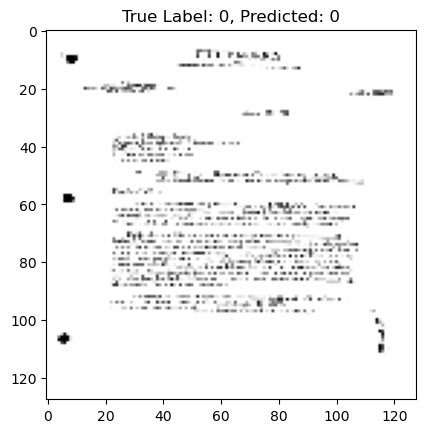

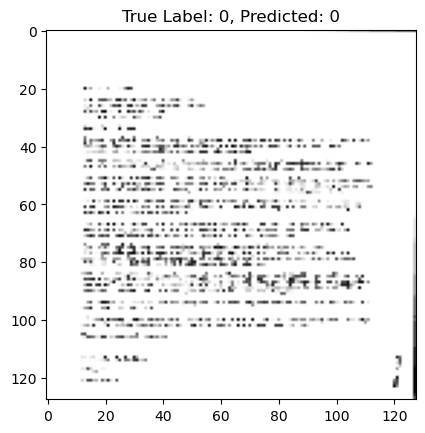

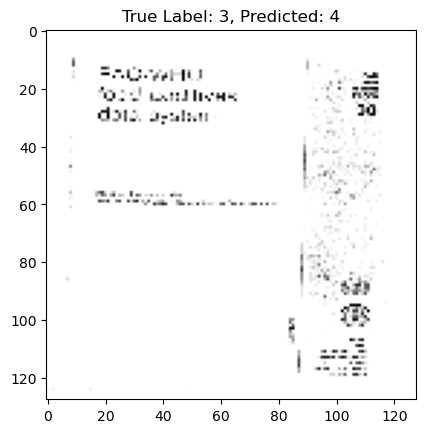

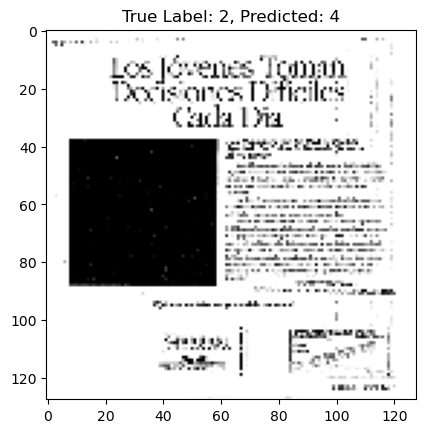

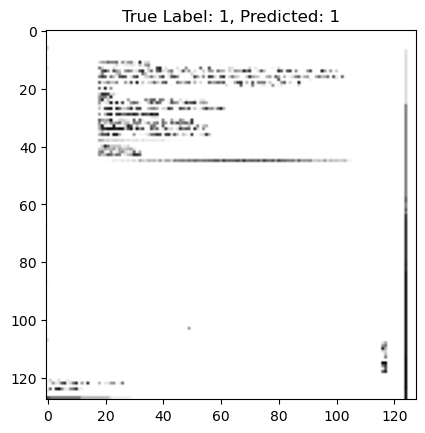

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select a few images
num_images_to_display = 5
random_indices = np.random.choice(len(test_image_data), num_images_to_display)

for idx in random_indices:
    plt.imshow(test_image_data[idx].squeeze(), cmap='gray')
    plt.title(f"True Label: {test_labels[idx]}, Predicted: {np.argmax(predictions[idx])}")
    plt.show()


# Overview of My Project:
**The Task:**

I had to make a computer tool that could sort pictures into five different groups. The interesting part was that each picture came with some text. This gave me an idea: What if I could use both the picture and its text to make decisions?

**The Steps I Took:**
**Getting to Know the Data:**

I had a set of 2,500 pictures, and each picture had a piece of text linked to it.
After seeing this, I thought it would be best to use both types of data for better accuracy.

**Building the Tool:**

For the pictures, I used a system known as a CNN. This system is known for being good at identifying patterns in images.
The text was handled using a different system that can process and understand written words.
I then combined the outputs of both these systems to make a final sorting decision.

**Organizing the Data:**

I adjusted the pictures so that they were of a consistent quality and size.
For the text, I made sure all the words were organized and easy for the computer to read.
Training the Tool:

Using the organized data, I then started teaching the tool how to sort the pictures.
I kept checking its performance regularly to ensure it was learning correctly.
Testing How Good the Tool Was:

Once the tool was trained, I tested it to see how accurate it was.
I also made a chart that showed which pictures were sorted correctly and which ones weren't.

**Why I Chose This Method:**
By using both pictures and their linked text, I believed the tool could make better decisions. While pictures show visual patterns, text can have important details that the picture might miss.

**Challenges:**

**Dealing with Text:**
Organizing and preparing the text was a bit challenging.
**Building the Tool:**
Combining two different systems (one for pictures and one for text) was new and a bit complex.
**Time:** The process was time-consuming, especially because I was using two types of data.

**Looking Back:**
If I had more time, I'd play around with other methods to see if I could get even better results. Using more advanced systems for reading the text might have been helpful too.

# My Thought Process Behind the Image-Text Classification Task

**First Impressions:**
When I first looked at the dataset, I was intrigued by its composition. Each image was paired with its corresponding OCR text. This duality got me thinking: Why not utilize both types of data to enhance the classification performance?

**Choosing the Model Architecture:**
Traditionally, I would employ Convolutional Neural Networks (CNNs) for image-related tasks due to their efficacy in handling visual patterns. But this time, I had the added dimension of OCR text data. I contemplated whether to integrate Dense layers for this textual data or experiment with more advanced text processing models. After weighing the pros and cons, I settled on creating a hybrid model that amalgamates both CNNs and Dense layers.

**Handling the Data:**
The saying goes that data is the fuel for machine learning, and this task reaffirmed that belief. I normalized the images to make the training smoother. The text data posed some challenges, though. I had to decide on an optimal token length post-tokenization. I knew I had to strike the right balance: too few tokens and I'd lose information; too many and I risked overfitting and lengthier training times.

**Training the Model:**
With the architecture ready and data in hand, I embarked on the training phase. Given the complexities of a hybrid model, I introduced checkpoints and early stopping mechanisms. I wanted to ensure that I captured the model at its best, and didn't waste time or computational power on unnecessary epochs.

**Evaluating Performance:**
Training a model is half the battle. I needed to know how well it performed. While accuracy is a good starting point, I always believe in a more holistic evaluation. I dove deeper, calculating precision, recall, F1 score, and also visualizing the results through a confusion matrix. This helped me identify the model's strengths and areas for potential improvement.

**Challenges Along the Way:**
It wasn't all smooth sailing. The very nature of a hybrid model brings its own set of challenges:

**Balancing Data Types:**
Integrating visual and textual data into one cohesive model meant I had to ensure neither type overshadowed the other.
Optimal Token Length: Deciding on the right token length for the text data was a bit of trial and error. I had to ensure I captured the essence of the text without overwhelming the model.

**Reflecting:**
Looking back, this project was a testament to the versatility of machine learning. Combining different data types and ensuring they harmoniously contribute to the end result was a challenge I thoroughly enjoyed. Given more time, I'd love to explore other architectures or even delve into transformer models for the text data. But for now, I'm content with the strides I've made in this project and am eager to see its real-world applications.

